In [1]:
import os
import cv2
import selectivesearch
import sys
# print current directory
print(os.getcwd())
sys.path.append("..")  # Go up one level, adjust as necessary

from module.utils import  (
    parse_xml, 
    prepare_proposals, 
    get_proposals, 
    calculate_iou, 
    load_image, 
    get_id,
    calc_recall, 
    calc_abo,
    from_xywh_to_min_max,
    visualize_image,
    resize_boxes)
from module.dataloader import (
    PotholeDataset
)
import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import torch.utils.data as data
# Moving active directory to root folder to get module to work

img_path = "../Potholes/annotated-images/"
anno_path = "../Potholes/annotated-images/"
proposal_path = "tmp/"
# This does not scale. We should save annotation proposals in a file. 

# IMAGE_WIDTH = 800
# IMAGE_HEIGHT = 800
# IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)


img_files = os.listdir(img_path)
proposal_files = os.listdir(proposal_path)

image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), img_files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), img_files)))
proposal_paths = np.array(list(filter(lambda file: file.endswith(".xml"), proposal_files)))
# sort the files
image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)
proposal_paths = sorted(proposal_files, key=get_id)

image_paths = image_paths[:]
label_paths = label_paths[:]
proposal_paths = proposal_paths[:]

gt_boxes = [parse_xml(anno_path + label_path) for label_path in label_paths]
images = [load_image(img_path + img) for img in image_paths]
proposals = [parse_xml(proposal_path + proposal) for proposal in proposal_paths]
# gt_boxes = [resize_boxes(boxs, (image.shape[1], image.shape[0]), IMAGE_SIZE) for boxs, image in zip(boxes, images)]

# Proposals and gt boxes are in a (xmin,ymin,xmax, ymax) format
# We want to calculate the iou for each image using gt and proposals

def calculate_average_split(proposals, ground_truth_boxes, iou_threshold=0.5):
    total_proposals = 0
    overlapping_proposals = 0

    for proposal_set, gt_boxes in zip(proposals, ground_truth_boxes):
        for proposal in proposal_set:
            proposal_box = from_xywh_to_min_max(proposal)
            for gt_box in gt_boxes:
                iou = calculate_iou(proposal_box, gt_box)
                if iou >= iou_threshold:
                    overlapping_proposals += 1
                    break
            total_proposals += 1

    average_split = overlapping_proposals / total_proposals if total_proposals > 0 else 0
    return average_split

def calculate_split_for_each_image(proposals, ground_truth_boxes, iou_threshold=0.5):
    splits = []

    for proposal_set, gt_boxes in zip(proposals, ground_truth_boxes):
        total_proposals = 0
        overlapping_proposals = 0
        for proposal in proposal_set:
            proposal_box = from_xywh_to_min_max(proposal)
            for gt_box in gt_boxes:
                iou = calculate_iou(proposal_box, gt_box)
                if iou >= iou_threshold:
                    overlapping_proposals += 1
                    break
            total_proposals += 1
        split = overlapping_proposals / total_proposals if total_proposals > 0 else 0
        splits.append(split)

    return splits

def calculate_recal(proposals, ground_truth_boxes, iou_threshold=0.5):

    recall = 0
    for proposal_set, gt_boxes in zip(proposals, ground_truth_boxes):
        recall += calc_recall(proposal_set, gt_boxes, iou_threshold)

    recall = recall / len(proposal_files)
    return recall

# Calculate the average split for the first 100 images
average_split = calculate_average_split(proposals, gt_boxes)
print(f"Average split of proposals (IoU >= 0.5): {average_split}")

average_recall = calculate_recal(proposals, gt_boxes)
print(f"average recall for (IoU >= 0.5): {average_recall}")




# Calculate the split for each of the first 100 images
# splits = calculate_split_for_each_image(proposals, boxes)
# for idx, split in enumerate(splits):
#     print(f"Image {idx + 1}: Split of proposals overlapping with gt boxes (IoU >= 0.5): {split}")


/zhome/81/e/154648/repos/Object-Detection/Rasmus
Average split of proposals (IoU >= 0.5): 0.03260302850990428
average recall for (IoU >= 0.5): 0.9478743290379972


In [2]:
potholeDataset = PotholeDataset(img_path, proposal_path, anno_path, image_size=None, proposals_per_batch=20, balance=0.5,iou_threshold=0.5,proposal_size=(128,128))

dataloader = data.DataLoader(potholeDataset, batch_size=1, shuffle=False)

# Test for the dataloader
There have been problems with calculate_iou resulting in a 

In [6]:
# compare np array with torch tensor
def compare_np_torch(np_array, torch_tensor):
    return np.all(np_array == torch_tensor.numpy())

def compare_labels_using_io(proposals, gt_boxes, iou_threshold=0.5):
    potholes = 0
    for proposal in proposals:
        for gt_box in gt_boxes:
            try:
                prop = from_xywh_to_min_max(proposal)
                
                iou = calculate_iou(prop, gt_box)
                if iou >= iou_threshold:
                    potholes += 1
                    break
            except Exception as e:
                print(proposal, gt_box)
                
    return potholes



potholes = 0
approximate_recall = 0
for _ in range(2):
    for i, data in tqdm.tqdm(enumerate(dataloader), total=len(potholeDataset)):
        t_image, t_proposals, t_gt = data['image'], data['proposals'], data['gt_boxes']
        potholes += compare_labels_using_io(t_proposals[0], t_gt[0], 0.5)
        approximate_recall += calc_recall(t_proposals[0], t_gt[0], 0.5)
        
potholes = potholes / len(potholeDataset) / 2
approximate_recall = approximate_recall / len(potholeDataset) / 2

100%|██████████| 662/662 [00:15<00:00, 43.38it/s]


In [7]:
print(potholes)
print(approximate_recall)


9.555891238670695
0.8781424578491758


In [10]:
iter = iter(dataloader)


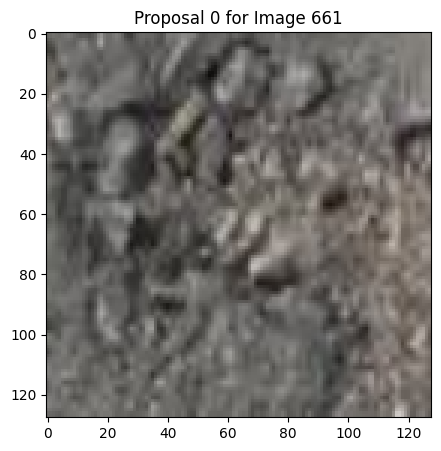

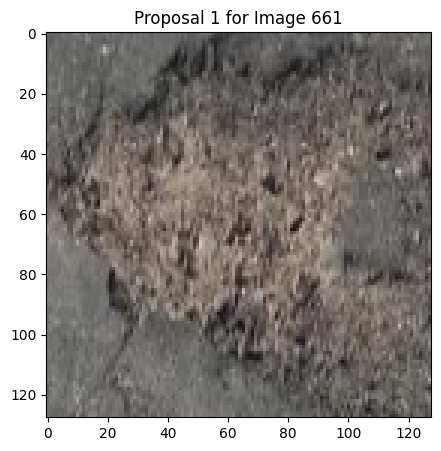

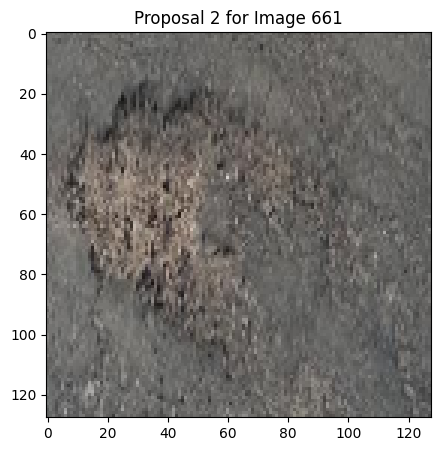

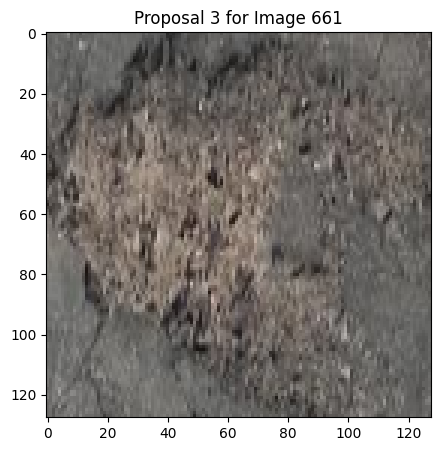

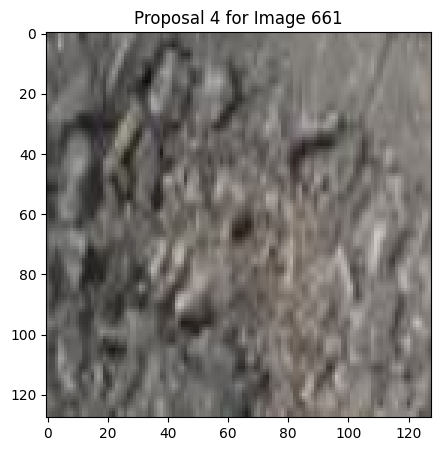

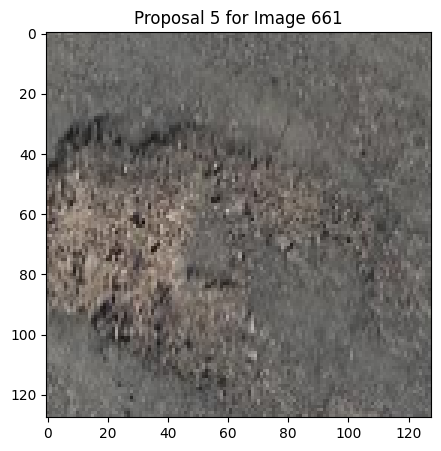

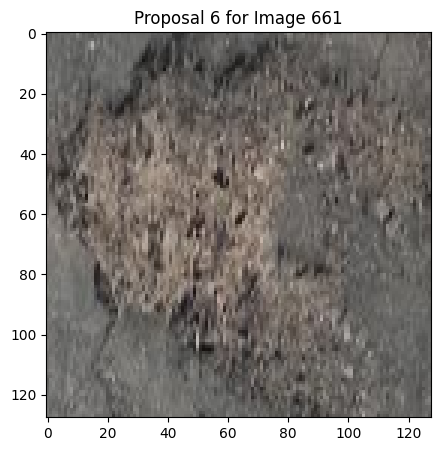

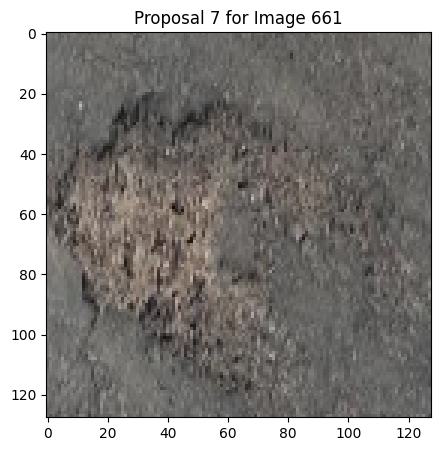

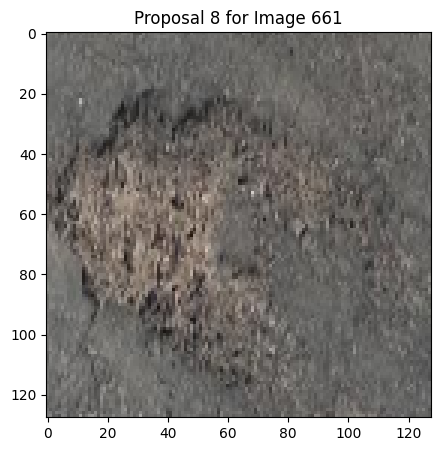

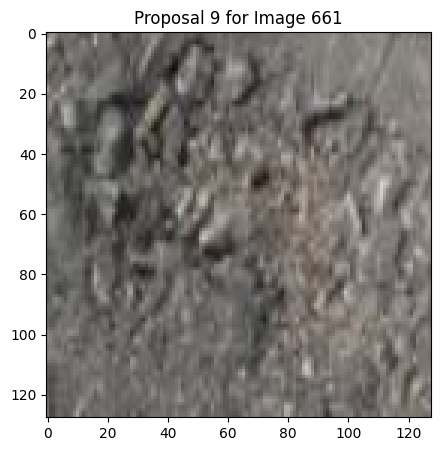

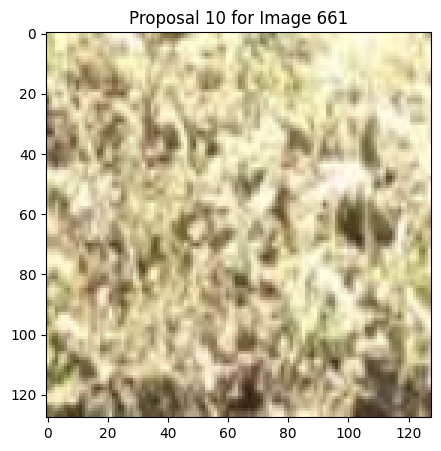

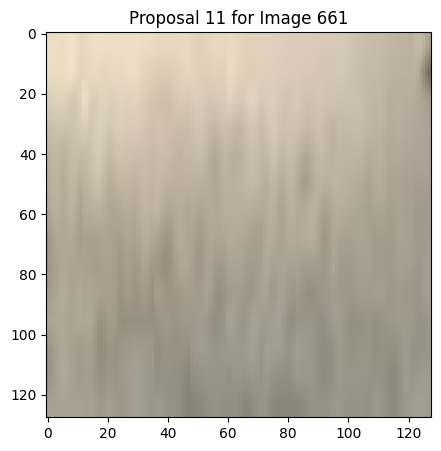

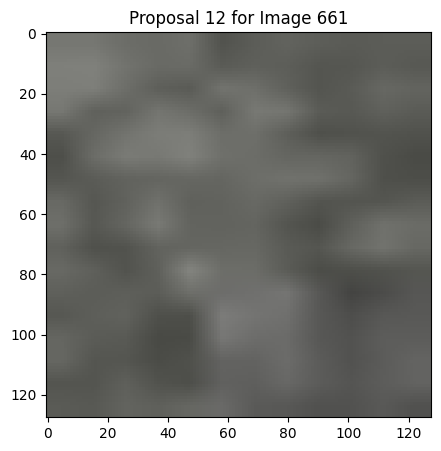

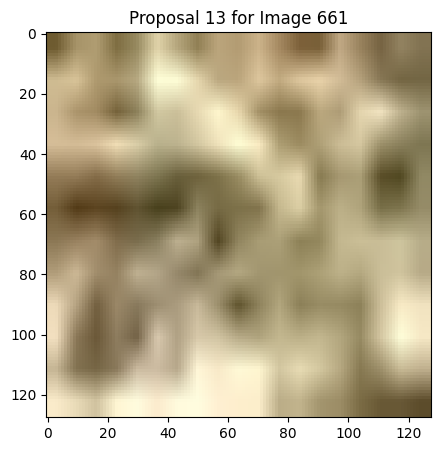

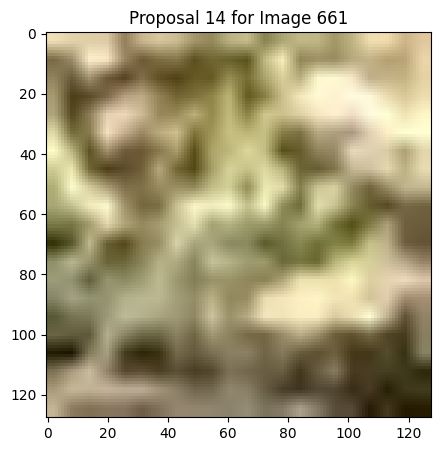

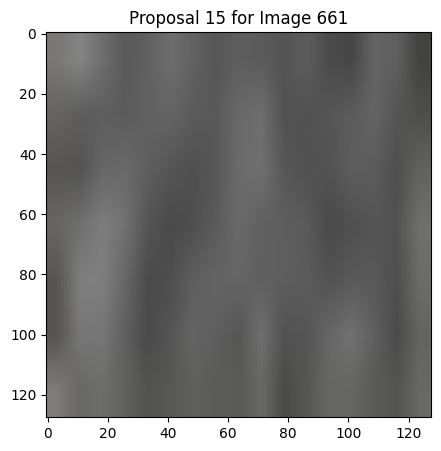

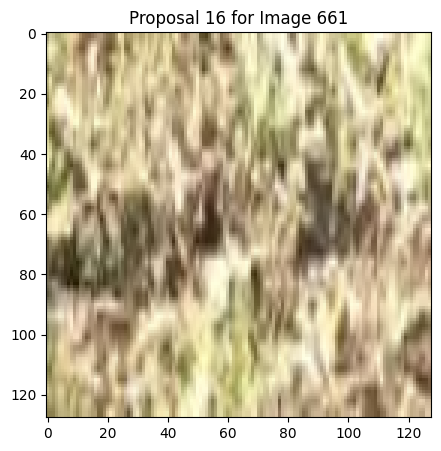

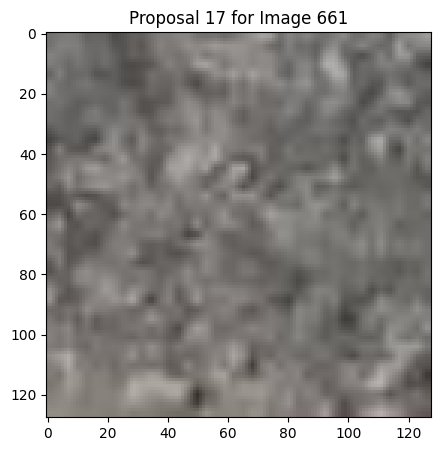

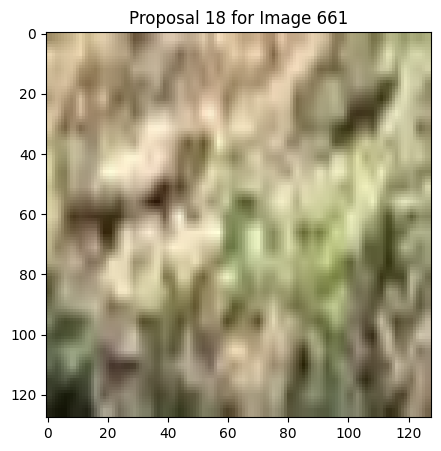

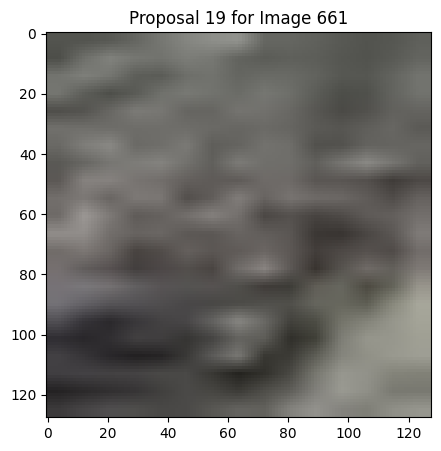

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of data


proposal_images = next(iter)['proposal_images']  # Assuming this is a list of proposals

# Plot all proposal images
for j in range(len(proposal_images)):
    # Convert each proposal image to numpy
    proposal_image = proposal_images[j][0].permute(1, 2, 0).numpy().astype(np.uint8)
        
    plt.figure(figsize=(5, 5))
    plt.imshow(proposal_image)
    plt.title(f"Proposal {j} for Image {i}")
    plt.show()
